In [1]:
# ===== STEP 1: Install Dependencies =====
!pip install opencv-python-headless kornia torch torchvision
!git clone https://github.com/verlab/accelerated_features.git
import sys
sys.path.append('/content/accelerated_features')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.3 MB/s eta 0:00:00
Cloning into 'accelerated_features'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 167 (delta 75), reused 35 (delta 35), pack-reused 55 (from 1)
Receiving objects: 100% (167/167), 20.10 MiB | 20.56 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [3]:
# ===== STEP 2: Import Libraries =====
import torch
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML, display, clear_output
from base64 import b64encode
import io
from PIL import Image

# Import XFeat
from modules.xfeat import XFeat

In [4]:
# ===== STEP 3: Initialize XFeat Model =====
print("Loading XFeat model...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xfeat = XFeat().to(device)
print(f"Model loaded on {device}")

Loading XFeat model...
loading weights from: /content/accelerated_features/modules/../weights/xfeat.pt
Model loaded on cpu


In [21]:


def preprocess_image(image, max_size=640):
    """Resize image while maintaining aspect ratio"""
    h, w = image.shape[:2]
    scale = min(max_size / max(h, w), 1.0)
    new_h, new_w = int(h * scale), int(w * scale)

    # Make dimensions divisible by 8
    new_h = (new_h // 8) * 8
    new_w = (new_w // 8) * 8

    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return resized, scale

def image_to_tensor(image, device):
    """Convert BGR image to RGB tensor"""
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    tensor = torch.from_numpy(rgb).permute(2, 0, 1).float() / 255.0
    return tensor.unsqueeze(0).to(device)

def extract_features_xfeat(image, xfeat_model, device, max_size=640):
    """Extract XFeat features from an image"""
    processed_img, scale = preprocess_image(image, max_size)
    tensor = image_to_tensor(processed_img, device)

    with torch.no_grad():
        output = xfeat_model.detectAndCompute(tensor, top_k=4096)[0]

    keypoints = output['keypoints']
    descriptors = output['descriptors']

    return keypoints, descriptors, scale, processed_img

def match_xfeat(xfeat_model, desc1, desc2, threshold=0.82):
    """Match descriptors using XFeat's built-in matcher"""
    with torch.no_grad():
        idx0, idx1 = xfeat_model.match(desc1, desc2, threshold)
    return idx0, idx1

def draw_matches_frame(ref_frame, ref_kp, curr_frame, curr_kp, matches_idx, max_display=100):
    """Draw matched keypoints between reference and current frame"""
    h1, w1 = ref_frame.shape[:2]
    h2, w2 = curr_frame.shape[:2]

    # Create side-by-side image
    h = max(h1, h2)
    w = w1 + w2
    canvas = np.zeros((h, w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = ref_frame
    canvas[:h2, w1:w1+w2] = curr_frame

    idx0, idx1 = matches_idx

    # Limit matches for visibility
    if len(idx0) > max_display:
        step = len(idx0) // max_display
        idx0 = idx0[::step]
        idx1 = idx1[::step]

    # Convert keypoints to numpy
    kp1_np = ref_kp[idx0].cpu().numpy()
    kp2_np = curr_kp[idx1].cpu().numpy()

    # Draw matches with green color like the original demo
    green_color = (0, 200, 0)  # Green in BGR format

    for i in range(len(kp1_np)):
        pt1 = tuple(map(int, kp1_np[i]))
        pt2 = tuple(map(int, kp2_np[i] + np.array([w1, 0])))

        cv2.line(canvas, pt1, pt2, green_color, 1, cv2.LINE_AA)
        cv2.circle(canvas, pt1, 3, green_color, -1, cv2.LINE_AA)
        cv2.circle(canvas, pt2, 3, green_color, -1, cv2.LINE_AA)

    return canvas

def create_display_frame(ref_frame, curr_frame, ref_kp, curr_kp, matches_idx, frame_idx, fps, num_matches):
    """Create the complete display frame with info overlay"""
    # Draw matches
    matched_img = draw_matches_frame(ref_frame, ref_kp, curr_frame, curr_kp, matches_idx)

    # Add info text
    h, w = matched_img.shape[:2]
    info_height = 50
    display_frame = np.zeros((h + info_height, w, 3), dtype=np.uint8)
    display_frame[info_height:, :] = matched_img

    # Add colored header
    cv2.rectangle(display_frame, (0, 0), (w, info_height), (240, 89, 169), -1)

    # Add text
    font = cv2.FONT_HERSHEY_SIMPLEX
    time_sec = frame_idx / fps if fps > 0 else 0

    text1 = f"Frame: {frame_idx} | Time: {time_sec:.2f}s | Matches: {num_matches}"
    text2 = f"Reference (Left) vs Current Frame (Right)"

    cv2.putText(display_frame, text1, (10, 25), font, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(display_frame, text2, (10, 45), font, 0.5, (200, 200, 200), 1, cv2.LINE_AA)

    return display_frame

In [6]:
# ===== STEP 5: Upload Query Image =====
print("\n=== UPLOAD REFERENCE IMAGE ===")
print("Upload the image you want to find in the video:")
uploaded_img = files.upload()
query_image_path = list(uploaded_img.keys())[0]


=== UPLOAD REFERENCE IMAGE ===
Upload the image you want to find in the video:


Saving WhatsApp Image 2025-12-08 at 11.08.22 AM.jpeg to WhatsApp Image 2025-12-08 at 11.08.22 AM.jpeg


Reference image loaded: (720, 1280, 3)
Extracting features from reference image...
Extracted 4096 keypoints from reference image


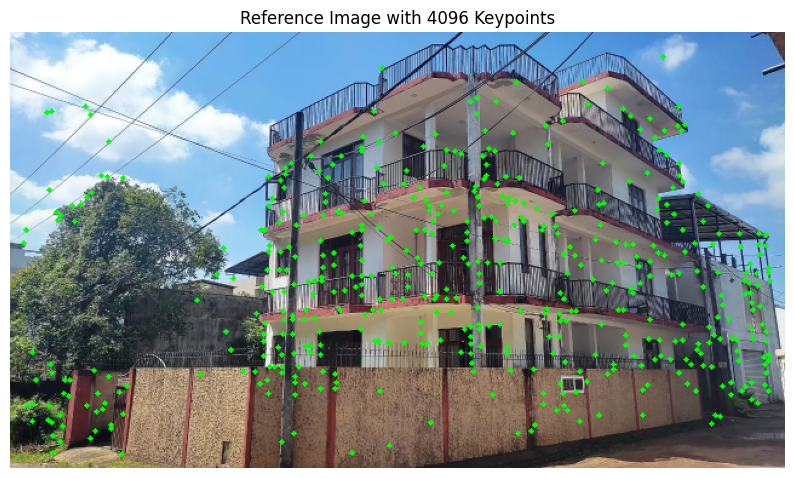

In [7]:
# Load and process query image
query_image = cv2.imread(query_image_path)
print(f"Reference image loaded: {query_image.shape}")

# Extract features from query image
print("Extracting features from reference image...")
ref_kp, ref_desc, ref_scale, ref_processed = extract_features_xfeat(
    query_image, xfeat, device, max_size=640
)
print(f"Extracted {len(ref_kp)} keypoints from reference image")

# Display reference image with keypoints
plt.figure(figsize=(10, 6))
display_img = ref_processed.copy()
kp_np = ref_kp.cpu().numpy()
for kp in kp_np[:500]:  # Show first 500 keypoints
    cv2.circle(display_img, tuple(map(int, kp)), 2, (0, 255, 0), -1)
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.title(f"Reference Image with {len(ref_kp)} Keypoints")
plt.axis('off')
plt.show()

In [9]:
# ===== STEP 6: Upload Video =====
print("\n=== UPLOAD VIDEO ===")
print("Upload the video to search in:")
uploaded_vid = files.upload()
video_path = list(uploaded_vid.keys())[0]


=== UPLOAD VIDEO ===
Upload the video to search in:


Saving VID_20251208_110328.mp4 to VID_20251208_110328.mp4


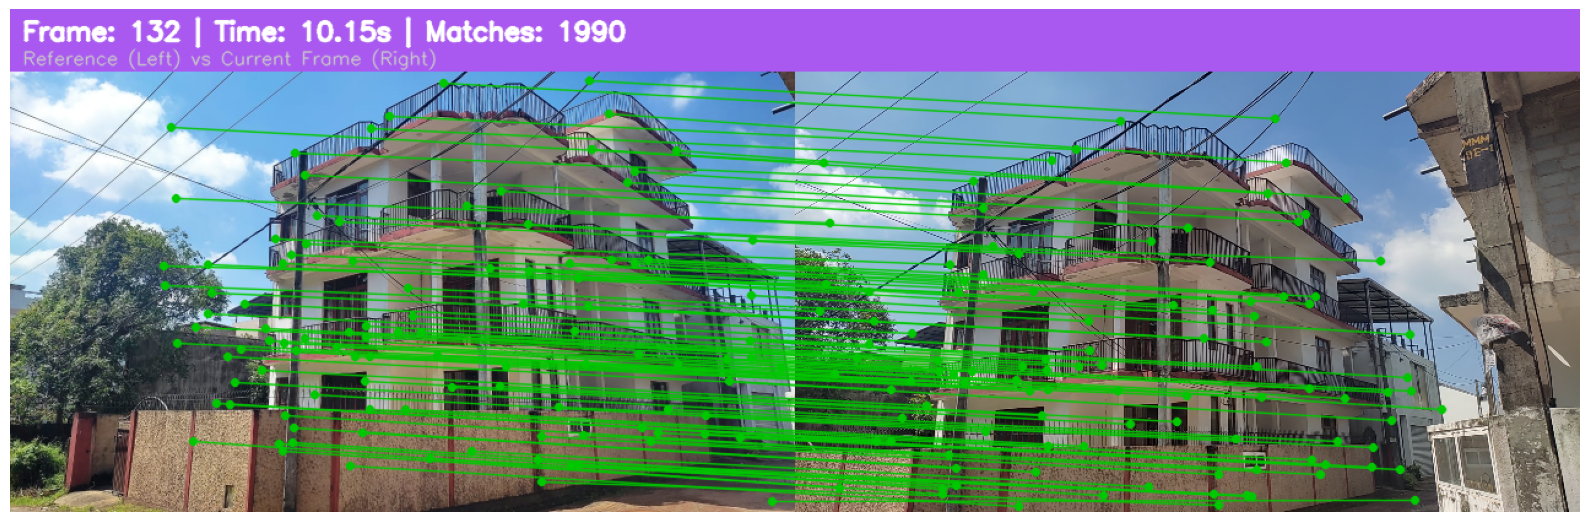

Frame 132/133 (10.2s) - 1990 matches

✅ Video saved successfully: matched_output.mp4


In [19]:
# # ===== STEP 7: Process Video with Real-time Visualization =====
# print("\n=== PROCESSING VIDEO ===")
# cap = cv2.VideoCapture(video_path)
# fps = int(cap.get(cv2.CAP_PROP_FPS))
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# print(f"Video: {total_frames} frames at {fps} FPS")
# print(f"Duration: {total_frames/fps:.1f} seconds")

# # Parameters
# frame_skip = max(1, fps // 5)  # Process 5 frames per second
# match_threshold = 0.82
# min_matches_display = 10

# print(f"\nProcessing every {frame_skip}th frame...")
# print("Displaying matches in real-time...\n")

# frame_idx = 0
# match_stats = []

# # For displaying in Colab
# from IPython.display import Image as IPImage, display, clear_output

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     if frame_idx % frame_skip == 0:
#         # Extract features from current frame
#         curr_kp, curr_desc, curr_scale, curr_processed = extract_features_xfeat(
#             frame, xfeat, device, max_size=640
#         )

#         # Match with reference image
#         idx0, idx1 = match_xfeat(xfeat, ref_desc, curr_desc, threshold=match_threshold)
#         num_matches = len(idx0)

#         # Store stats
#         match_stats.append({
#             'frame': frame_idx,
#             'time': frame_idx / fps,
#             'matches': num_matches
#         })

#         # Only display if sufficient matches
#         if num_matches >= min_matches_display:
#             # Create display frame
#             display_frame = create_display_frame(
#                 ref_processed, curr_processed,
#                 ref_kp, curr_kp,
#                 (idx0, idx1),
#                 frame_idx, fps, num_matches
#             )

#             # Convert to RGB for display
#             display_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

#             # Display in Colab
#             clear_output(wait=True)
#             plt.figure(figsize=(16, 8))
#             plt.imshow(display_rgb)
#             plt.axis('off')
#             plt.tight_layout()
#             plt.show()

#             print(f"Frame {frame_idx}/{total_frames} ({frame_idx/fps:.1f}s) - {num_matches} matches")

#     frame_idx += 1

#     # Progress update every second
#     if frame_idx % fps == 0:
#         progress = (frame_idx / total_frames) * 100
#         print(f"Progress: {progress:.1f}% ({frame_idx}/{total_frames} frames)")

# cap.release()
# ===== STEP 7: Process Video with Real-time Visualization =====
print("\n=== PROCESSING VIDEO ===")
cap = cv2.VideoCapture(video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {total_frames} frames at {fps} FPS")
print(f"Duration: {total_frames/fps:.1f} seconds")

# Parameters
frame_skip = max(1, fps // 5)  # Process 5 frames per second
match_threshold = 0.82
min_matches_display = 10
output_video_path = 'matched_output.mp4'

print(f"\nProcessing every {frame_skip}th frame...")
print("Displaying matches in real-time and saving to video...\n")

frame_idx = 0
match_stats = []
video_writer = None
last_display_frame = None

# For displaying in Colab
from IPython.display import Image as IPImage, display, clear_output

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_idx % frame_skip == 0:
        # Extract features from current frame
        curr_kp, curr_desc, curr_scale, curr_processed = extract_features_xfeat(
            frame, xfeat, device, max_size=640
        )

        # Match with reference image
        idx0, idx1 = match_xfeat(xfeat, ref_desc, curr_desc, threshold=match_threshold)
        num_matches = len(idx0)

        # Store stats
        match_stats.append({
            'frame': frame_idx,
            'time': frame_idx / fps,
            'matches': num_matches
        })

        # Create display frame (always, even with few matches)
        display_frame = create_display_frame(
            ref_processed, curr_processed,
            ref_kp, curr_kp,
            (idx0, idx1),
            frame_idx, fps, num_matches
        )

        # Initialize video writer on first frame
        if video_writer is None:
            h, w = display_frame.shape[:2]
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            output_fps = fps / frame_skip  # Actual output FPS
            video_writer = cv2.VideoWriter(output_video_path, fourcc, output_fps, (w, h))
            print(f"Saving video to: {output_video_path} at {output_fps:.1f} FPS")

        # Write frame to video
        video_writer.write(display_frame)
        last_display_frame = display_frame

        # Only display if sufficient matches (to avoid clutter)
        if num_matches >= min_matches_display:
            # Convert to RGB for display
            display_rgb = cv2.cvtColor(display_frame, cv2.COLOR_BGR2RGB)

            # Display in Colab
            clear_output(wait=True)
            plt.figure(figsize=(16, 8))
            plt.imshow(display_rgb)
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            print(f"Frame {frame_idx}/{total_frames} ({frame_idx/fps:.1f}s) - {num_matches} matches")

    frame_idx += 1

    # Progress update every second
    if frame_idx % fps == 0:
        progress = (frame_idx / total_frames) * 100
        print(f"Progress: {progress:.1f}% ({frame_idx}/{total_frames} frames)")

cap.release()
if video_writer is not None:
    video_writer.release()
    print(f"\n✅ Video saved successfully: {output_video_path}")
else:
    print("\n⚠️ No frames were processed.")


=== PROCESSING COMPLETE ===

📥 Downloading output video...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Download started!

Total frames processed: 67
Frames with 10+ matches: 67

=== TOP 10 MATCHING FRAMES ===
1. Frame 76 at 5.8s - 2528 matches
2. Frame 74 at 5.7s - 2499 matches
3. Frame 80 at 6.2s - 2496 matches
4. Frame 78 at 6.0s - 2417 matches
5. Frame 72 at 5.5s - 2404 matches
6. Frame 66 at 5.1s - 2395 matches
7. Frame 68 at 5.2s - 2392 matches
8. Frame 64 at 4.9s - 2386 matches
9. Frame 70 at 5.4s - 2372 matches
10. Frame 62 at 4.8s - 2360 matches


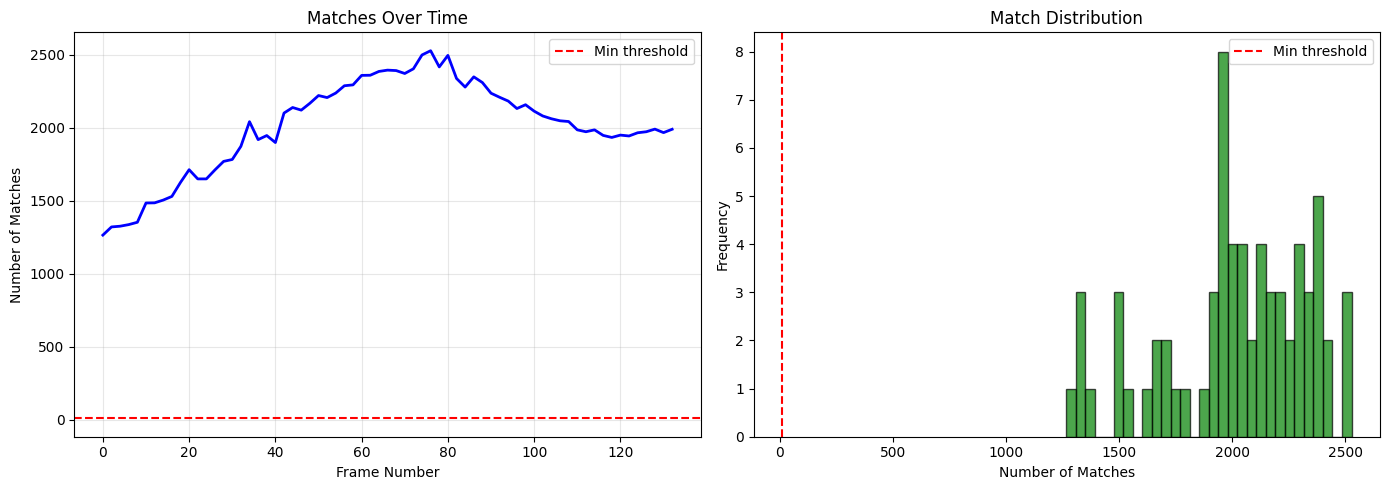


=== DONE ===
To process another video, re-run from Step 6
To use a different reference image, re-run from Step 5


In [20]:
# ===== STEP 8: Summary, Statistics, and Download Video =====
print("\n" + "="*60)
print("=== PROCESSING COMPLETE ===")
print("="*60)

# Download the output video
if Path(output_video_path).exists():
    print(f"\n📥 Downloading output video...")
    files.download(output_video_path)
    print("✅ Download started!")

if len(match_stats) > 0:
    # Filter frames with good matches
    good_matches = [s for s in match_stats if s['matches'] >= min_matches_display]

    print(f"\nTotal frames processed: {len(match_stats)}")
    print(f"Frames with {min_matches_display}+ matches: {len(good_matches)}")

    if len(good_matches) > 0:
        # Sort by number of matches
        good_matches.sort(key=lambda x: x['matches'], reverse=True)

        print("\n=== TOP 10 MATCHING FRAMES ===")
        for i, stat in enumerate(good_matches[:10], 1):
            print(f"{i}. Frame {stat['frame']} at {stat['time']:.1f}s - {stat['matches']} matches")

        # Plot match statistics
        plt.figure(figsize=(14, 5))

        # Plot 1: Matches over time
        plt.subplot(1, 2, 1)
        frames = [s['frame'] for s in match_stats]
        matches = [s['matches'] for s in match_stats]
        plt.plot(frames, matches, linewidth=2, color='blue')
        plt.axhline(y=min_matches_display, color='r', linestyle='--', label='Min threshold')
        plt.xlabel('Frame Number')
        plt.ylabel('Number of Matches')
        plt.title('Matches Over Time')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Plot 2: Match distribution
        plt.subplot(1, 2, 2)
        plt.hist(matches, bins=30, color='green', alpha=0.7, edgecolor='black')
        plt.axvline(x=min_matches_display, color='r', linestyle='--', label='Min threshold')
        plt.xlabel('Number of Matches')
        plt.ylabel('Frequency')
        plt.title('Match Distribution')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("\nNo frames found with sufficient matches.")
        print(f"Try lowering the threshold (current: {match_threshold}) or min_matches_display (current: {min_matches_display})")
else:
    print("\nNo frames were processed. Check your video file.")

print("\n=== DONE ===")
print("To process another video, re-run from Step 6")
print("To use a different reference image, re-run from Step 5")